In [3]:
import json
import os
import numpy as np


def read_raw(rec_path, timestamp, data_type):
    data = None
    with open(os.path.join(rec_path, f'{data_type}_{timestamp}.txt')) as f:
        data = json.load(f)
    return data

def extract_quat_array(data, offset=None):
    data = [[val['x'], val['y'], val['z'], val['w']] for val in data]
    data = np.array(data)
    if offset is not None:
        return data[offset:]
    return data


def extract_vec3_array(data, offset=None, is_homogeneous=False):
    if is_homogeneous:
        data = [[val['x'], val['y'], val['z'], 1.0] for val in data]
    else:
        data = [[val['x'], val['y'], val['z']] for val in data]
    data = np.array(data)
    if offset is not None:
        return data[offset:]
    return data




def get_processed_hl_data(rec_path, plot=False, interp=False):
    rec_name = rec_path.split('\\')[-1]
    folder_timestamp = list(filter(lambda x: 'WatchSensors_' in x, os.listdir(rec_path)))[0].split('_')[1].split('.')[0]
    watch = read_raw(rec_path, folder_timestamp, "WatchSensors")

    #### Extract Key Information
    GLOBAL_REC_OFFSET = 1

    watch = watch[GLOBAL_REC_OFFSET:]
    watch_acc = [val for frame in watch for val in frame['acc']]
    watch_acc = extract_vec3_array(watch_acc, is_homogeneous=False)[1:]
    watch_gyr = [val for frame in watch for val in frame['gyro']]
    watch_gyr = extract_vec3_array(watch_gyr)[1:]

    watch_acc_ts = np.array([ts for frame in watch for ts in frame['accTS']])
    watch_acc_ts = [int((ts - watch_acc_ts[0])/1000000) for ts in watch_acc_ts[1:]]
    watch_acc_dts = np.array([(watch_acc_ts[i+1] - watch_acc_ts[i]) / 1000.0 for i in range(len(watch_acc_ts) - 1)])
    # watch_acc_ts = np.array([ts - watch_acc_ts[0] for ts in watch_acc_ts[1:]])
    watch_acc_ts = np.array(watch_acc_ts)

    watch_gyr_ts = np.array([ts for frame in watch for ts in frame['gyroTS']])
    watch_gyr_ts = [int((ts - watch_gyr_ts[0])/1000000) for ts in watch_gyr_ts[1:]]
    watch_gyr_dts = np.array([(watch_gyr_ts[i+1] - watch_gyr_ts[i]) / 1000.0 for i in range(len(watch_gyr_ts) - 1)])
    # watch_gyr_ts = np.array([ts - watch_gyr_ts[1] for ts in watch_gyr_ts[1:]])
    watch_gyr_ts = np.array(watch_gyr_ts)

    print(f"Watch Duration: {watch_acc_ts[-1]}")

    return watch_acc,watch_acc_ts,watch_gyr,watch_gyr_ts

def get_processed_activity_data(rec_path, plot=False, interp=False):
    folder_timestamp = list(filter(lambda x: 'ActivityLabels_' in x, os.listdir(rec_path)))[0].split('_')[1].split('.')[0]
    watch = read_raw(rec_path, folder_timestamp, "ActivityLabels")

    #### Extract Key Information
    watch_activity = [frame['activityName'] for frame in watch]
    activity_ts = [frame['_recTS'] for frame in watch]

    return watch_activity, activity_ts



In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

#functions for training and validation
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    avg_loss_across_batches = running_loss / len(test_loader)
    print('Train Loss: {0:.3f}'.format(avg_loss_across_batches))
    print()
    return avg_loss_across_batches


def validate_one_epoch():
    model.train(False)
    running_loss_val = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch_test, y_batch_test = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output_test = model(x_batch_test)
            loss_test = loss_function(output_test, y_batch_test)
            running_loss_val += loss_test.item()

    avg_loss_across_batches_val = running_loss_val / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches_val))
    print('***************************************************')
    print()
    return avg_loss_across_batches_val


In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# get paths to recordings
rec_path = "drive/MyDrive/watch_activity_model/Recs"
#rec_path = "drive/MyDrive/watch_activity_model/Test_Data"
recs = [os.path.join(rec_path, filename) for filename in os.listdir(rec_path)]


In [6]:
!ls drive/MyDrive/watch_activity_model/Recs/rec_12
print(device)


ActivityLabels_1043.txt  WatchSensors_1043.txt
cuda:0


In [17]:
x_data = []
y_data = []
labels = np.eye(4)

#lentgh of the sequence can be set here (time window = seq_lentgh / 40Hz)
seq_length = 40

for rec in recs:
    print(rec)
    watch_acc, watch_acc_ts, watch_gyr, watch_gyr_ts = get_processed_hl_data(rec)
    watch_data = np.hstack((watch_acc, watch_gyr))
    activity, TS = get_processed_activity_data(rec)

    size_rec = len(watch_data)//seq_length
    modulo = len(watch_data) % seq_length
    if modulo < int(seq_length/2):
        size_rec -= 1

    x = np.zeros((2*size_rec, seq_length, 6))
    y = np.zeros((2*size_rec,seq_length, 4))

    #helper variables
    activity_data = np.zeros((len(watch_data), 4))
    counter = 0
    k = 0

    for c in range(len(watch_data)):

        activity_data[c] = labels[k]

        if TS[counter] < c:
            if counter % 2 == 0:
                if activity[counter] == 'cut':
                    k = 1
                if activity[counter] == 'whisk':
                    k = 2
                if activity[counter] == 'put_into':
                    k = 3
            else:
                k = 0
            activity_data[c] = labels[k]
            counter += 1

        if counter == len(TS):
            counter = 0
            TS[0] = 1000000000

    for i in range(size_rec):
      
        index1 = seq_length*i
        index2 = index1 + int(seq_length/2)

        x[2*i] = watch_data[index1:index1+seq_length]
        x[(2*i)+1] = watch_data[index2:(index2 + seq_length)]
        y[2*i] = activity_data[index1:index1+seq_length]
        y[(2*i)+1] = activity_data[index2:(index2 + seq_length)]

    x_data.append(x)
    y_data.append(y)

x_data = np.concatenate(x_data, axis=0)
y_data = np.concatenate(y_data, axis=0)
print(x_data.shape, y_data.shape)


drive/MyDrive/watch_activity_model/Recs/rec_5
Watch Duration: 16167
drive/MyDrive/watch_activity_model/Recs/rec_2
Watch Duration: 17949
drive/MyDrive/watch_activity_model/Recs/rec_1
Watch Duration: 22456
drive/MyDrive/watch_activity_model/Recs/rec_3
Watch Duration: 12885
drive/MyDrive/watch_activity_model/Recs/rec_6
Watch Duration: 20464
drive/MyDrive/watch_activity_model/Recs/rec_7
Watch Duration: 24150
drive/MyDrive/watch_activity_model/Recs/rec_4
Watch Duration: 17497
drive/MyDrive/watch_activity_model/Recs/rec_12
Watch Duration: 25992
drive/MyDrive/watch_activity_model/Recs/rec_16
Watch Duration: 24442
drive/MyDrive/watch_activity_model/Recs/rec_13
Watch Duration: 27043
drive/MyDrive/watch_activity_model/Recs/rec_9
Watch Duration: 20861
drive/MyDrive/watch_activity_model/Recs/rec_17
Watch Duration: 24862
drive/MyDrive/watch_activity_model/Recs/rec_10
Watch Duration: 25366
drive/MyDrive/watch_activity_model/Recs/rec_15
Watch Duration: 25838
drive/MyDrive/watch_activity_model/Recs/re

In [18]:
#define train, validation and test dataloaders:

split_index = int(len(x_data) * 0.8)
X_train = x_data[:split_index]
X_test = x_data[split_index:]

y_train = y_data[:split_index]
y_test = y_data[split_index:]

In [19]:
#only if you want to normalize the input data

from sklearn.preprocessing import StandardScaler

# Reshape to 2D
X_train_2D = X_train.reshape(-1, X_train.shape[-1])

# Apply scaling
scaler = StandardScaler()
X_train_2D = scaler.fit_transform(X_train_2D)

# Reshape back to 3D
X_train = X_train_2D.reshape(X_train.shape)

# Similarly for X_test
X_test_2D = X_test.reshape(-1, X_test.shape[-1])
X_test_2D = scaler.transform(X_test_2D)  # Note use of transform, not fit_transform
X_test = X_test_2D.reshape(X_test.shape)




In [20]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

In [10]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [21]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
class LSTM(nn.Module):
    def __init__(self, input_size=6, hidden_dim=128, num_layers=1, output_dim=4):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_dim, num_layers, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.bn1 = nn.BatchNorm1d(hidden_dim//2)  # Add batch normalization
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(hidden_dim//2, output_dim)

    def forward(self, input):

        batch_size = input.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)

        lstm_out, _ = self.lstm(input, (h0, c0))  # lstm_out shape : batch_size x seq_length x hidden_dim

        out = self.fc1(lstm_out)  # out shape : batch_size x seq_length x hidden_dim//2

        out = out.transpose(1, 2)  # out shape : batch_size x hidden_dim//2 x seq_length
        out = self.bn1(out)  # batch normalization over hidden_dim//2
        out = out.transpose(1, 2)  # out shape : batch_size x seq_length x hidden_dim//2

        out = self.relu(out)
        out = self.dropout(out)

        out = self.fc2(out)  # out shape : batch_size x seq_length x output_dim

        return out

In [22]:

model = LSTM()
model.to(device)

LSTM(
  (lstm): LSTM(6, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

In [105]:
#define training loop:

learning_rate = 0.005
num_epochs = 100
# loss_function = nn.CrossEntropyLoss()
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
avg_loss = 0.0
avg_loss_val = 0.0
val_th = 0.08
train_th = 0.1
for epoch in range(num_epochs):
    avg_loss = train_one_epoch()
    avg_loss_val = validate_one_epoch()
    # if(avg_loss_val < val_th):
    if(avg_loss < train_th):
      break

Epoch: 1
Train Loss: 0.347

Val Loss: 0.093
***************************************************

Epoch: 2
Train Loss: 0.332

Val Loss: 0.106
***************************************************

Epoch: 3
Train Loss: 0.323

Val Loss: 0.099
***************************************************

Epoch: 4
Train Loss: 0.272

Val Loss: 0.093
***************************************************

Epoch: 5
Train Loss: 0.275

Val Loss: 0.089
***************************************************

Epoch: 6
Train Loss: 0.228

Val Loss: 0.072
***************************************************

Epoch: 7
Train Loss: 0.214

Val Loss: 0.074
***************************************************

Epoch: 8
Train Loss: 0.227

Val Loss: 0.105
***************************************************

Epoch: 9
Train Loss: 0.202

Val Loss: 0.075
***************************************************

Epoch: 10
Train Loss: 0.211

Val Loss: 0.075
***************************************************

Epoch: 11
Train Loss: 0.208



torch.Size([224, 40, 6])


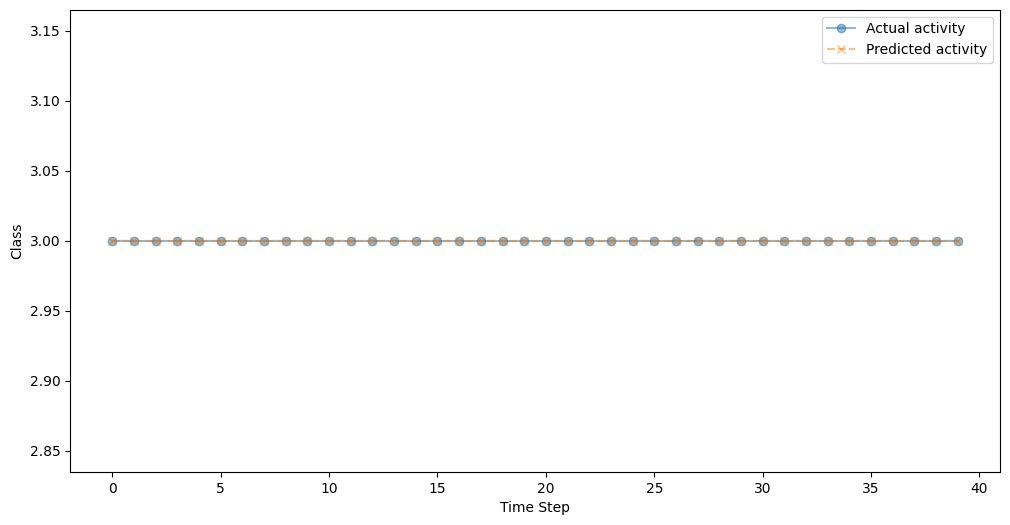

In [15]:

# Visualize
with torch.no_grad():
    logits = model(X_test.to(device))
    print(X_test.shape)
    # Shape of logits: (batch_size, sequence_length, num_classes)

# sequence index [0:224]
sequence_index = 101

# Predicted classes for each time step in the sequence
predicted = torch.argmax(logits[sequence_index], dim=-1).to('cpu').numpy()
# Shape of predicted: (sequence_length,)

# Actual classes for each time step in the sequence
actual = np.argmax(y_test[sequence_index], axis=-1)
# Shape of actual: (sequence_length,)

plt.figure(figsize=(12, 6))
plt.plot(actual, label='Actual activity', linestyle='-', marker='o', alpha=0.5)
plt.plot(predicted, label='Predicted activity', linestyle='--', marker='x', alpha=0.5)
plt.xlabel('Time Step')
plt.ylabel('Class')
plt.legend()
plt.show()


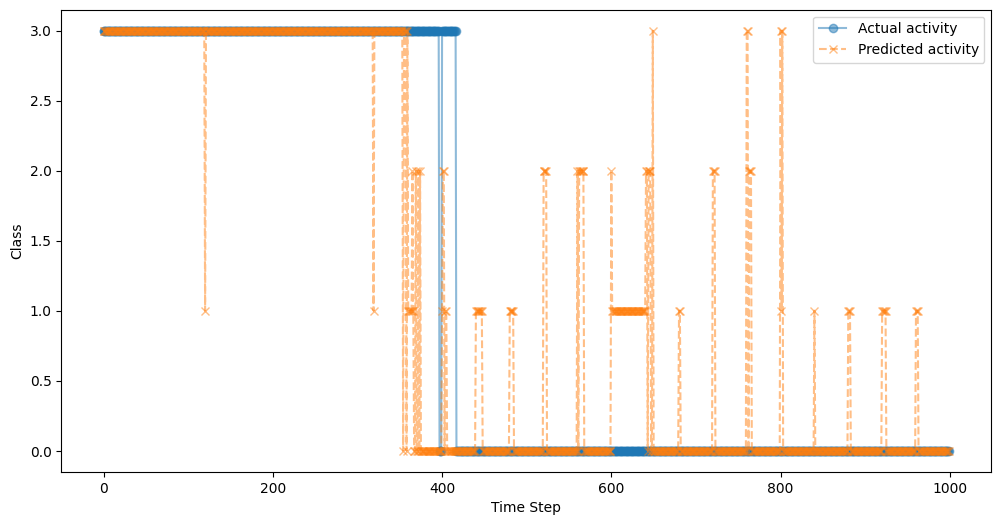

In [24]:
# Visualize
with torch.no_grad():
    logits = model(X_test.to(device))
    # Shape of logits: (batch_size, sequence_length, num_classes)

# Predicted classes for each time step in the sequence
predicted = torch.argmax(logits, dim=-1).to('cpu').numpy().reshape(-1)
# Shape of predicted: (batch_size*sequence_length,)

# Actual classes for each time step in the sequence
actual = np.argmax(y_test, axis=-1).reshape(-1)
# Shape of actual: (batch_size*sequence_length,)
end = 224*40
list_start = 4000
list_end = 5000
# list_start = 0
# list_end = end
act = actual[list_start:list_end]
pred = predicted[list_start:list_end]
plt.figure(figsize=(12, 6))
plt.plot(act, label='Actual activity', linestyle='-', marker='o', alpha=0.5)
plt.plot(pred, label='Predicted activity', linestyle='--', marker='x', alpha=0.5)
plt.xlabel('Time Step')
plt.ylabel('Class')
plt.legend()
plt.show()


In [ ]:
actual = np.argmax(y_test, axis=-1)
print(actual)
print(logits)

In [83]:
!ls drive/MyDrive/watch_activity_model/Recs
save_path = "drive/MyDrive/watch_activity_model/Models/model_.pt"
torch.save(model.state_dict(), save_path)

rec_1	rec_12	rec_15	rec_18	rec_20	rec_23	rec_3  rec_6  rec_9
rec_10	rec_13	rec_16	rec_19	rec_21	rec_24	rec_4  rec_7
rec_11	rec_14	rec_17	rec_2	rec_22	rec_25	rec_5  rec_8


In [ ]:
# Save
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)


In [23]:
!ls drive/MyDrive/watch_activity_model
load_path = "drive/MyDrive/watch_activity_model/Models/model_many_to_many.pt"
# Load weights only
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint)

#Load weights and optimizer state
#model.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model_1sec_sequence.pt	Models			  Recs
model_no_preprocess.pt	NN_every_timestamp.ipynb  Test_Data
model_nopreprocess.pt	NN_test.ipynb		  Untitled0.ipynb


<All keys matched successfully>